In [1]:
import warnings

from typing import (Union, NoReturn, Optional,
                    Tuple, List)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings('ignore')

plt.style.use('seaborn-darkgrid')
np.random.seed(0)

%matplotlib inline

In [2]:
train = pd.read_csv('../input/liverpool-ion-switching/train.csv')
test = pd.read_csv('../input/liverpool-ion-switching/test.csv')

In [3]:
batch_size = 500_000

In [4]:
def make_batches(data: pd.DataFrame,
                batch_size: int,
                num_batches: int) -> List:
    
    batches = []
    
    for i in range(num_batches):
        batches.append(data[i * batch_size: (i + 1) * batch_size])
        
    return batches

It was found in EDA that the test set can be divided into 12 batches. First 10 with a batch size of 100,000 and the last 2 with a batch size of 500,000

In [5]:
train_batches = make_batches(train, batch_size, 10)

test_batches = make_batches(test, 100_000, 10) + \
                make_batches(test[10 * 100_000:], batch_size, 2)

# Remove drift

A sine function of the form $\hat{y} = A sin(\omega t + \varphi) + \delta$ and $\omega = 2 \pi f$ where $f$ is the frequency of the signal, $\varphi$ is the phase of the signal and $\delta$ is a factor added to shift the origin can be used to approximate the drift. Once a good approximation for the drift is found, we simply subtract the actual signal from the value produced by the approximation to drift. The idea is to find a function such that (Given function) - (Drift function) = (Clean function)

There are three parameters to be found, namely, $A, \varphi$ and  $\delta$. Since, each batch can have different parameters, we do this for each batch separately. 

Here, the batch size is $500,000 \times 10^{-4} s$, i.e, $50 s$, and the drift is only from the first half of the sine wave. So, $\omega = \frac{2 \pi}{50 \times 2}$. We divide by 2 because the time period of half sine wave is half that of a full sine wave.  We have, 

$$\hat{y} = A sin(\omega x + \varphi) + \delta$$

We expand $sin$ by using $sin(A + B) = sin(A)cos(B) + cos(A)sin(B)$

$$\hat{y} = Asin(\omega x)cos(\varphi) + Acos(\omega x)sin(\varphi) + \delta$$

further rearranging, 

$$\hat{y} = Acos(\varphi)sin(\omega x) + Asin(\varphi)cos(\omega x) + \delta$$

Here, finding the three constants, namely $Acos(\varphi),\; Asin(\varphi),\;$and $\delta$, will give us an approximation to the drift function.  Since we have $N = 500,000$ observations(1 batch), we need to solve a system of linear equations for which the above equation holds.

$$\begin{bmatrix}
\sin(\omega x_1) & \cos(\omega x_1) & 1 \\
\vdots & \vdots & \vdots \\
\sin(\omega x_N) & \cos(\omega x_N) & 1
\end{bmatrix}
\begin{bmatrix}
A\cos(\varphi) \\
A\sin(\varphi) \\
\delta
\end{bmatrix} = 
\begin{bmatrix}
y_1 \\ \vdots \\ y_N
\end{bmatrix}$$

$\mathbf{x} = (x_1, \cdots, x_N)$, is the time of observation, and $\mathbf{y} = (y_1, \cdots, y_N)$ is the signal observed at that time. In short,

$$\mathbf{M}\mathbf{\theta} = \mathbf{y}$$


Here $\theta = (\theta_1, \theta_2, \theta_3)\;$ is the vector of the constants we intend to find. Notice that, $A^2 = \theta_1^2 + \theta_2^2$, as $sin^2(x) + cos^2(x) = 1$, and $\varphi = tan^{-1}(\frac{\theta_2}{\theta_1})$ as $tan(x) = \frac{sin(x)}{cos(x)}$

Once the drift function is obtained, all we have to do is to subtract it from the original signal to eliminate it

In [6]:
def approximate_drift(data: pd.DataFrame) -> Tuple[float, float, float]:
    '''
    fits a sin wave to the data
    
    returns the amplitude, the phase and shift of the fit sine wave
    '''
    
    x = data['time'].values
    y = data['signal'].values
    
    frequency = 0.01
    omega = 2 * np.pi * frequency
    
    # create the matrix M
    # M is of shape (N, 3), where N is the number of timesteps(= 500,000) in the data
    # for each timestep t, in data compute [cos(const * t), sin(const * t), 1]. This is `M`
    
    M = np.array([
        [np.sin(omega * t), np.cos(omega * t), 1] for t in x
    ])
    
    # y contains the signal strength a each timestep
    # reshape it to a Matrix of len(y) rows and only one column
    y = y.reshape(-1, 1)
    
    # to find the solution to the above system of linear equation ( M * theta = y) programmaticaly
    # we use least squares, i.e., Linear regression
    # numpy linear least square returns 4 values: the solutions, the resudials, the rank and the singular values
    # we keep only the least squares fit
    # the returned solution `theta` is a matrix of shape (3, 1)
    (theta, _, _, _) = np.linalg.lstsq(M, y, rcond=None)
    
    # As mentioned above we have to find three constants
    # find A
    A = np.sqrt(theta[0, 0] ** 2 + theta[1, 0] ** 2)
    
    # find phi
    phi = np.arctan2(theta[1, 0], theta[0, 0])
    
    return A, phi

From EDA we found linear drift in batch 2, and parabolic drift in batches 6 through 10 in the training set. In test set linear drift occurs 1, 2, 5, 7, 8, 9 and parabolic drift occurs only in batch 11.

In [7]:
train_parabolic_drift_idx = [6, 7, 8, 9]

params = []
for i in train_parabolic_drift_idx:
    params.append(approximate_drift(train_batches[i]))
params.append(approximate_drift(test_batches[10]))

pd.DataFrame(params, columns=['A', 'phi'])

,A,phi
0,4.995587,0.000574
1,5.070119,3.138266
2,4.962839,0.000536
3,5.074016,3.136019
4,4.999814,-0.002040


The amplitude for all of the parabolic drift is approximately 5 and the angle phi is either $\pi$ or 0. It's $\pi$ when the index is odd and 0 otherwise. This phase difference comes because the negative part is not considered. We will use these to remove drift

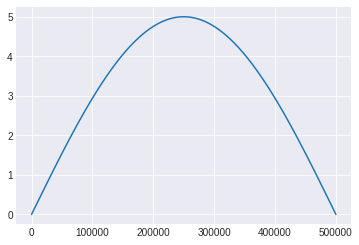

In [8]:
def drift_fn(x: np.array, 
             A: float) -> np.array:
    '''
    returns a sine wave formed by the given arguments 
    '''
    
    f = 1 / batch_size
    
    # since we work with only the sine wave in [0, pi]
    omega = np.pi * f
    return A * np.sin(omega * x)

x = np.arange(0, batch_size)
sine_drift = drift_fn(x, 5)
plt.plot(x, sine_drift)
plt.show()

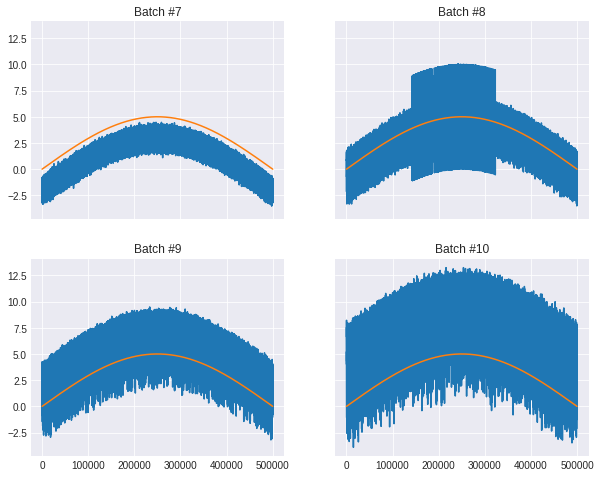

In [9]:
train_parabolic_drift_idx = [6, 7, 8, 9]

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(10, 8))

x = np.arange(0, batch_size)

index = 0
for i in range(2):
    for j in range(2):
        batch_id = train_parabolic_drift_idx[index]
        index += 1
        
        signal = train_batches[batch_id]['signal']
        
        axes[i, j].plot(x, signal)
        axes[i, j].plot(x, sine_drift)
        axes[i, j].title.set_text(f'Batch #{batch_id + 1}')

plt.show()

In [10]:
def plot_all_batches(data: pd.DataFrame,
                    title: Union[str, None] = None) -> NoReturn:
    
    plt.figure(figsize=(25, 5))
    plt.title(title)
    plt.ylabel('signal')
    plt.xlabel('time')
    
    for batch in data:
        plt.plot(batch['time'], batch['signal'], linewidth=0.1)

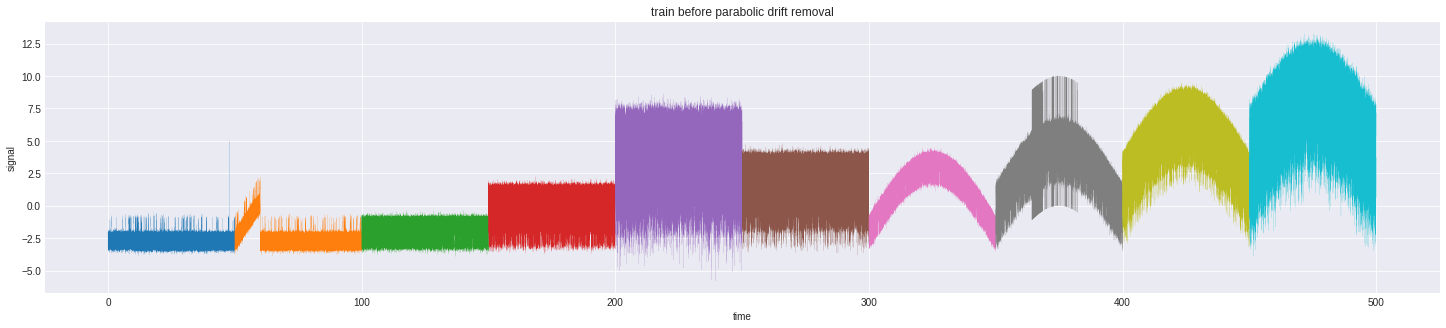

In [11]:
plot_all_batches(train_batches, 'train before parabolic drift removal')

we now use the sine drift to remove all parabolic drift

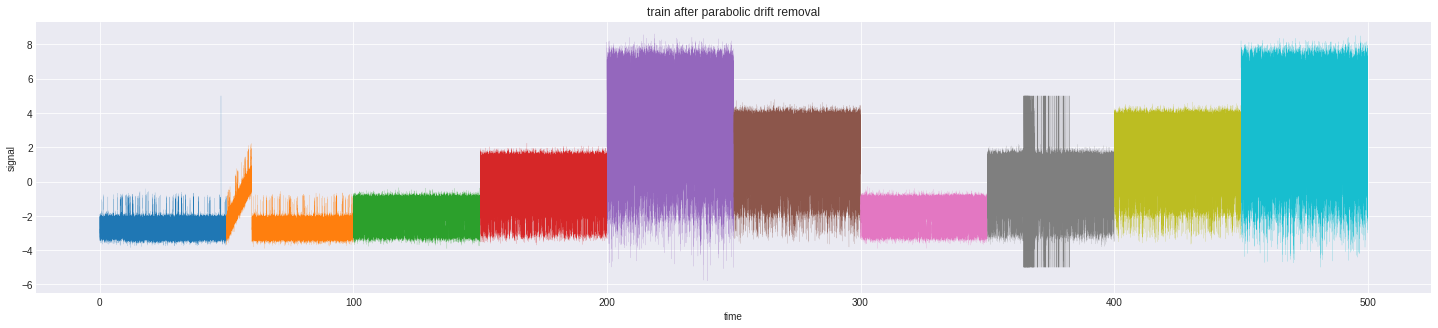

In [12]:
for i in train_parabolic_drift_idx:
    train_batches[i]['signal'] = train_batches[i]['signal'] - sine_drift
    
plot_all_batches(train_batches, 'train after parabolic drift removal')

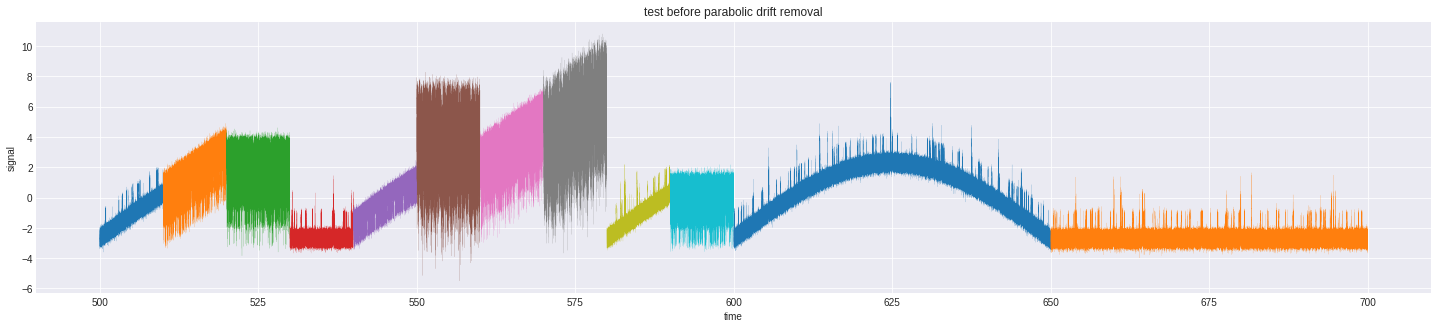

In [13]:
plot_all_batches(test_batches, 'test before parabolic drift removal')

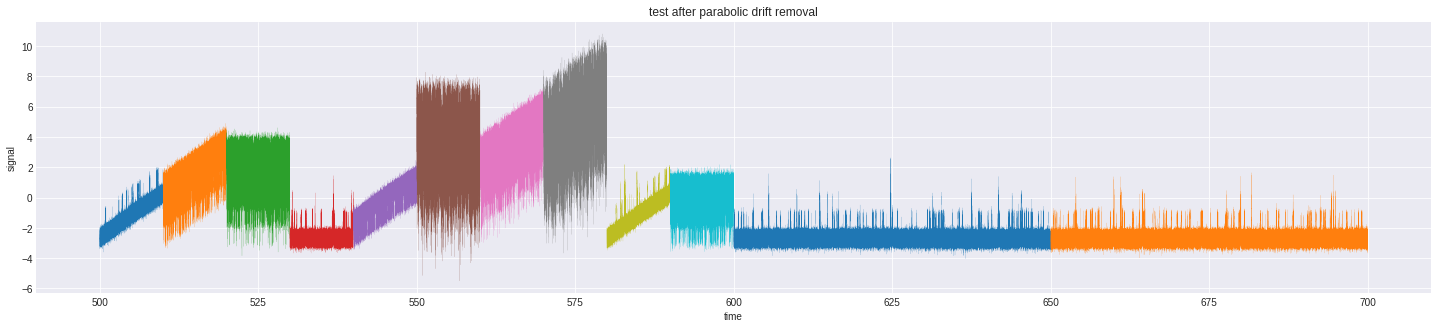

In [14]:
test_batches[10]['signal'] = test_batches[10]['signal'] - sine_drift

plot_all_batches(test_batches, 'test after parabolic drift removal')

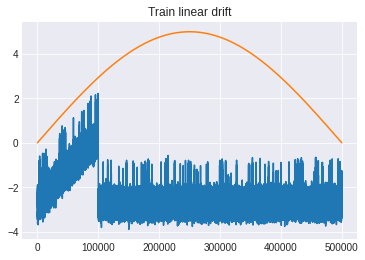

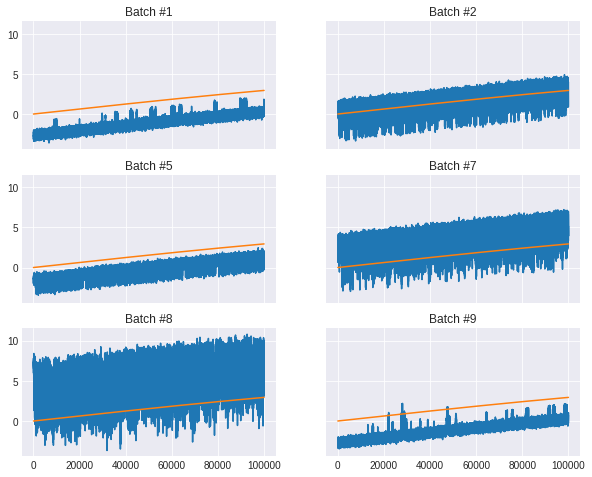

In [15]:
test_linear_drift_idx = [0, 1, 4, 6, 7, 8]


x = np.arange(0, batch_size)
signal = train_batches[1]['signal']
plt.plot(x, signal)
plt.plot(x, sine_drift)
plt.title('Train linear drift')


x = x[:100_000]
linear_drift = sine_drift[:100_000]
fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(10, 8))
plt.title('Test linear drift')

index = 0
for i in range(3):
    for j in range(2):
        batch_id = test_linear_drift_idx[index]
        index += 1
        
        signal = test_batches[batch_id]['signal']
        
        axes[i, j].plot(x, signal)
        axes[i, j].plot(x, linear_drift)
        axes[i, j].title.set_text(f'Batch #{batch_id + 1}')

plt.show()

It can be clearly seen that the first 100_000 points of the sine drift causes linear drift.

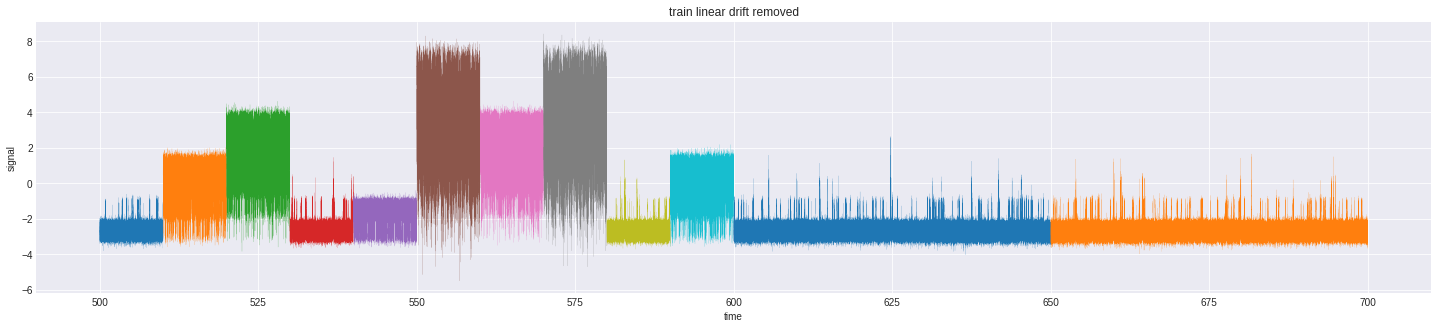

In [16]:
for i in test_linear_drift_idx:
    test_batches[i]['signal'] = test_batches[i]['signal'] - linear_drift
plot_all_batches(test_batches, 'train linear drift removed')

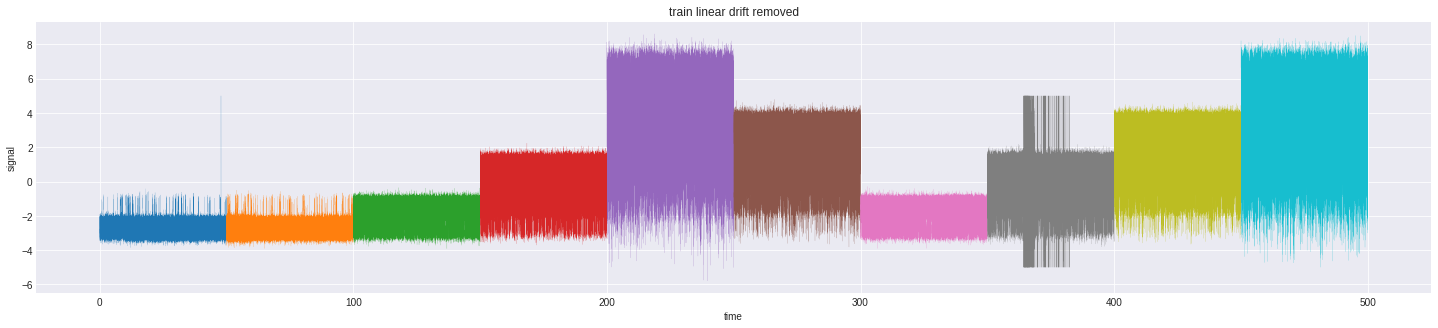

In [17]:
train_batches[1].iloc[:100_000]['signal'] = train_batches[1].iloc[:100_000]['signal'] - linear_drift

plot_all_batches(train_batches, 'train linear drift removed')

The data now is clean of drift

In [18]:
train_clean = train_batches[0]
test_clean = test_batches[0]

for batch in train_batches[1:]:
    train_clean = pd.concat([train_clean, batch], ignore_index=True)
for batch in test_batches[1:]:
    test_clean = pd.concat([test_clean, batch], ignore_index=True)

# Linear transforms

## Zero mean off set

We try to get all open zero channels and zero signal to the same base

In [19]:
signal = train_clean.loc[train['open_channels'] == 0, 'signal']
signal.mean()

-2.727552813763441

In [20]:
train_clean['signal'] = train_clean['signal'] + 2.728
test_clean['signal'] = test_clean['signal'] + 2.728

## scale and shift

In [21]:
from sklearn.linear_model import LinearRegression

# The start of our batches (* 100_000). Both train and test
start_of_batch = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] + \
                          [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 65, 70]) # test batches

# groups as identified by EDA. Consisting of both train and test groups
groups = np.array([1, 1, 2, 3, 5, 4, 2, 3, 4, 5] + \
                  [6, 3, 4, 6, 2, 5, 4, 5, 6, 3, 6, 6]) # groups test

In [22]:
for group in range(1, 6):
    # Take the training data corresponding to this category
    indices = np.where(groups[:-11] == group)[0]
    starts = start_of_batch[indices]
    ends = start_of_batch[indices + 1]
    X = []
    y = []
    for start, end in zip(starts, ends):
        subsignal = train_clean['signal'].values[start * 100_000: end * 100_000]
        subtarget = train_clean['open_channels'].values[start * 100_000: end * 100_000]
        
        # Skip the anomalous part between 3.6M - 3.9M
        if start == 35:
            subsignal = list(subsignal[:100_000]) + list(subsignal[-100_000:])
            subtarget = list(subtarget[:100_000]) + list(subtarget[-100_000:])
        
        X.extend(subsignal)
        y.extend(subtarget)
    X = np.array(X)
    y = np.array(y)
    
    # Create a dataframe with our values, than groupby the open channel
    # values and take the mean
    df = pd.DataFrame(np.hstack((X.reshape(-1, 1),
                                 y.reshape(-1, 1))),
                      columns=['X', 'y'])
    means = df.groupby('y')[['X']].mean()
    X = means['X'].values
    y = means.index.values
    
    # Fit Linear Regression on the means.
    lr = LinearRegression()
    lr.fit(X.reshape(-1, 1), y)
    print(group, lr.intercept_, lr.coef_)  

1 -0.001785851415936901 [0.8086224]
2 0.005370923336992572 [0.81071412]
3 0.006709190935882292 [0.81240392]
4 0.012109693800744559 [0.80972641]
5 2.263041321844487 [0.80219263]


In [23]:
offsets = [-0.001, 0.005, 0.007, 0.012, 2.263, 0.005]
slope = 0.81

signal = np.concatenate((train_clean['signal'].values, test_clean['signal'].values))
for i, (start, end) in enumerate(zip(start_of_batch[:-1], start_of_batch[1:])):
    group = groups[i] - 1
    signal[start * 100_000: end * 100_000] = offsets[group] + slope * signal[start * 100_000: end * 100_000]
    

train_len = len(train)

train_clean['signal'] = signal[:train_len]
test_clean['signal'] = signal[train_len:]

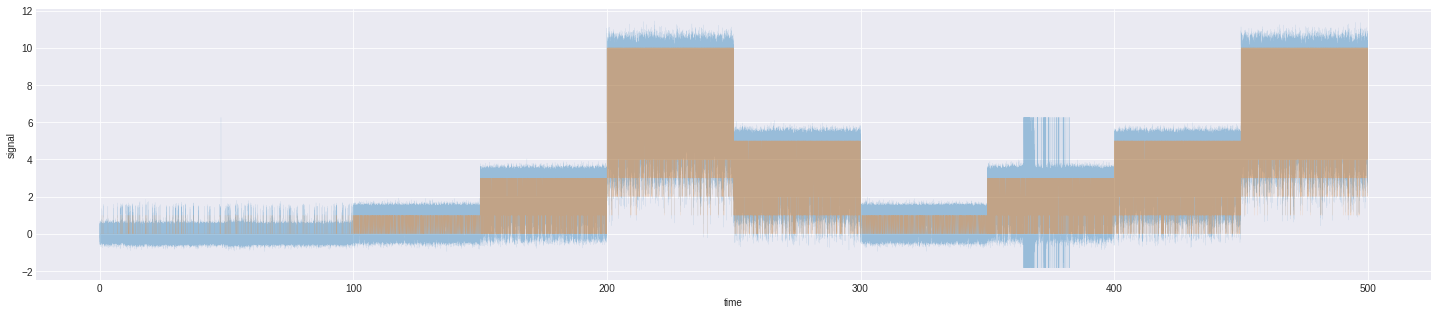

In [24]:
plt.figure(figsize=(25, 5))
plt.plot(train_clean['time'], train_clean['signal'], linewidth=0.1, alpha=0.4)
plt.plot(train_clean['time'], train_clean['open_channels'], linewidth=0.1, alpha=0.4)
plt.ylabel('signal')
plt.xlabel('time')
plt.show()

# Remove outliers

Batch 1 and 7 from the train data has spikes. This spike in the future may prevent training. As the plot shows the data from 478_000 to 479_000 of batch 1 and 3_641_000 to 3_829_000 of batch 7 has spikes unlike other batches of the data. In a simpler sense the data in this region is corrupted. One way to handle this corruption is to simply avoid using the corrupted part in the data. But doing so will result in data loss. We must find a way to clean the data.

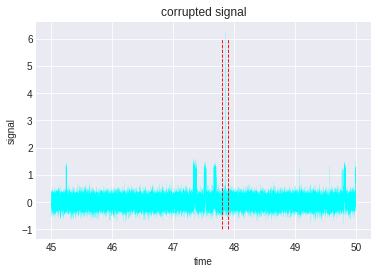

In [25]:
plt.plot(train_clean['time'][450_000:500_000], train_clean['signal'][450_000:500_000], 'cyan', linewidth=0.1)
plt.plot([47.8, 47.8], [-1, 6], 'r--', linewidth=0.9)
plt.plot([47.9, 47.9], [-1, 6], 'r--', linewidth=0.9)
plt.title('corrupted signal')
plt.ylabel('signal')
plt.xlabel('time')
plt.show()

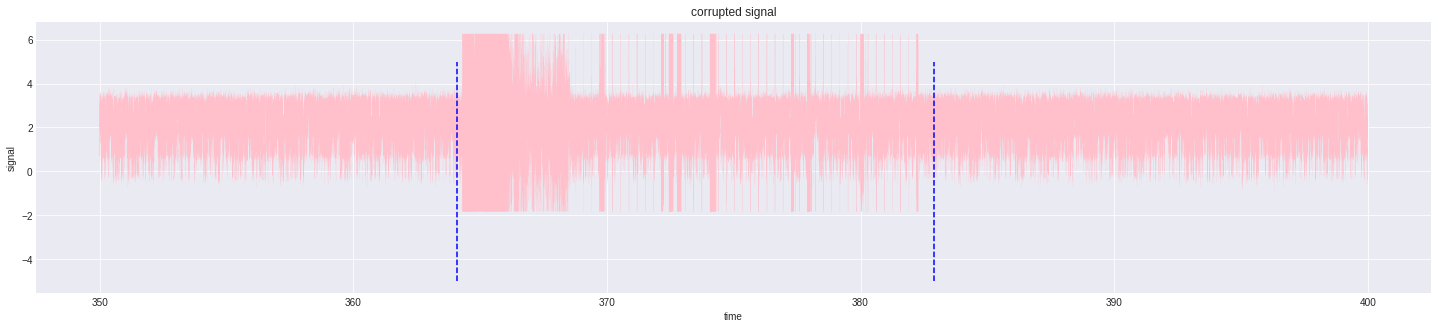

In [26]:
# Plot the corrupted signal
plt.figure(figsize=(25, 5))
plt.title('corrupted signal')
plt.ylabel('signal')
plt.xlabel('time')
plt.plot(train_clean['time'][3500000: 4000000], train_clean['signal'][3500000: 4000000], 'pink', linewidth=0.1)
plt.plot([364.1, 364.1], [-5, 5], 'b--')
plt.plot([382.9, 382.9], [-5, 5], 'b--')
plt.show()

We will use signal - round(signal) as a proxy for noise

In [27]:
train_clean['noise_round'] = train_clean['signal'] - train_clean['signal'].round()

train_clean['batch'] = np.arange(len(train_clean)) // 500_000

train_clean.groupby('batch')['noise_round'].agg(['mean', 'std'])

,mean,std
batch,,
0,0.004347,0.196532
1,-0.002519,0.197846
2,-0.001597,0.196585
3,-0.004519,0.211793
4,0.009901,0.269060
5,0.003943,0.223591
6,-0.000390,0.196657
7,0.000174,0.225435
8,-0.003064,0.222450


Since most of the channels have std arround 0.2, we will sinply substitute the corrupted part with its open channels with gaussian noise of std = 0.2

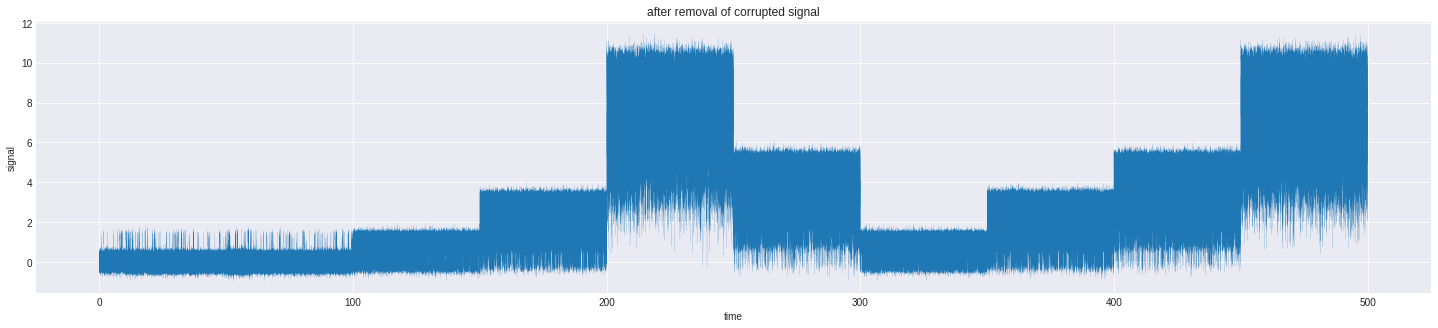

In [28]:
## Batch 1
corrupted_data = train_clean.loc[478_000: 479_000]
corrupted_data['signal'] = corrupted_data['open_channels'] + np.random.normal(0, 0.22, len(corrupted_data))

train_clean.loc[3_641_000: 3_829_000, 'signal'] = corrupted_data['signal']

## Batch 7
corrupted_data = train_clean.loc[3_641_000: 3_829_000]
corrupted_data['signal'] = corrupted_data['open_channels'] + np.random.normal(0, 0.22, len(corrupted_data))

train_clean.loc[3_641_000: 3_829_000, 'signal'] = corrupted_data['signal']


plt.figure(figsize=(25, 5))
plt.title('after removal of corrupted signal')
plt.ylabel('signal')
plt.xlabel('time')
plt.plot(train_clean['time'], train_clean['signal'], linewidth=0.1)
plt.show()

# Noise
## Remove bias
because the signal has a lot of noise, machine learning models tend to under perform as they try to approximate the noise. We iteratively remove this until noise is acceptable

In [29]:
train_clean['noise_round'] = train_clean['signal'] - train_clean['signal'].round()
test_clean['noise_round'] = test_clean['signal'] - test_clean['signal'].round()

train_clean['batch'] = np.arange(len(train_clean)) // 500_000
test_clean['batch'] = np.arange(len(test_clean)) // 100_000

# remove bias in signal
for _ in range(7):
    train_clean['bias'] = train_clean.groupby('batch')['noise_round'].transform('mean')
    test_clean['bias'] = test_clean.groupby( 'batch')['noise_round'].transform('mean')
    
    train_clean['signal'] = train_clean['signal'] - train_clean['bias']
    test_clean['signal'] = test_clean['signal'] - test_clean['bias']
    
    train_clean['noise_round'] = train_clean['signal'] - train_clean['signal'].round()
    test_clean['noise_round'] = test_clean['signal'] - test_clean['signal'].round()

In [30]:
train_clean.drop(['noise_round', 'batch', 'bias'], axis=1, inplace=True)
test_clean.drop(['noise_round', 'batch', 'bias'], axis=1, inplace=True)

## Denoise signal
Since this is a signal, we use a signal processing approach to de-noise the data. Kalman filters seem particularly hopeful

In [31]:
from pykalman import KalmanFilter

# Apply kalman filter on train data
initial_value_guess = train_clean['signal'].iloc[0]

# fit and smooth signal using kalman filter
kalman = KalmanFilter(initial_state_mean=initial_value_guess,
                      transition_covariance=0.1,
                      observation_covariance=0.0015,
                      initial_state_covariance=0.0015,
                      transition_matrices=1)

smooth_signal, _ = kalman.smooth(train_clean['signal'])

train_clean['signal'] = smooth_signal


In [32]:
# Apply kalman filter on test data
initial_value_guess = test_clean['signal'].iloc[0]

kalman = KalmanFilter(initial_state_mean=initial_value_guess,
                      transition_covariance=0.1,
                      observation_covariance=0.0015,
                      initial_state_covariance=0.0015,
                      transition_matrices=1)


smooth_signal, _ = kalman.smooth(test_clean['signal'])


test_clean['signal'] = smooth_signal

## Decrease noise from power line interference

Since the data was collected by plugging a device into an electrical socket, some noise from the electrical socket will also be included. Total removal of this noise may lead to important information about the data being lost. We use fast fourier transform to remove about 45% of the noise. We restrict the frequency to the range [49.8, 50.2] as this is range at which power is delivered. We do this in batches of 100k points

In [33]:
from scipy.fft import fftfreq

def decrease_power_line_noise(data: pd.DataFrame,
                             batch_size: int = 100_000,
                             rate: float = 0.55) -> NoReturn:


    for i in range(len(data) // batch_size):

        # compute the fast fourier transform for each batch
        fft = np.fft.fft(data.iloc[i * batch_size: (i + 1) * batch_size]['signal'])

        # get frequencies of the transform.
        # The resolution here is the time interval between two observations
        freq = np.abs(fftfreq(len(fft), d=0.0001))

        # select the frequencies the needs to be decreased
        fft[(freq >= 49.8) & (freq <= 50.2)] = rate * fft[(freq >= 49.8) & (freq <= 50.2)]

        # perform the inverse fourier transform to get the signal back
        # this signal will have the selected frequencies reduced
        data.iloc[i * batch_size: (i + 1) * batch_size]['signal'] = np.fft.ifft(fft).real


In [34]:
decrease_power_line_noise(train_clean)
decrease_power_line_noise(test_clean)

In [35]:
train_clean.to_csv('train.csv', index=False)
test_clean.to_csv('test.csv', index=False)